In [1]:
import matplotlib.pyplot as plt
import numpy as np

from microlensing.IPM.ipm import IPM

from microlensing.Lightcurves import lightcurves
from microlensing.SourceProfiles import uniform_disk, gaussian

/mnt/lustre2/shared_conda/envs/weisluke/microlensing/lib/python3.13/site-packages/cupyx/jit/_interface.py:173: FutureWarning: cupyx.jit.rawkernel is experimental. The interface can change in the future.
  cupy._util.experimental('cupyx.jit.rawkernel')


# Creating a magnification map

In [2]:
ipm = IPM(verbose=1,
          kappa_tot=0.4, shear=0.4, kappa_star=0.2, 
          half_length_y1=25, half_length_y2=25, 
          num_pixels_y1=5000, num_pixels_y2=5000
          )
ipm.random_seed = 0
ipm.run()

Generating star field...
Done generating star field. Elapsed time: 0 seconds.

Creating children and sorting stars...
Done creating children and sorting stars. Elapsed time: 0.067 seconds.

Calculating multipole and local coefficients...
Done calculating multipole and local coefficients. Elapsed time: 0.07 seconds.

Shooting cells...
100 %
Done shooting cells. Elapsed time: 1.885 seconds.



# Creating supernovae lightcurves

In [3]:
# create an array of expanding disks up to a radius of 100 pixels
# note the plural UniformDisks here as opposed to UniformDisk
source = uniform_disk.UniformDisks(100)

positions = 100 # 100 random positions

lcs, positions = lightcurves.changing_source(ipm, source, positions, return_pos=True) # return random positions so we can plot them

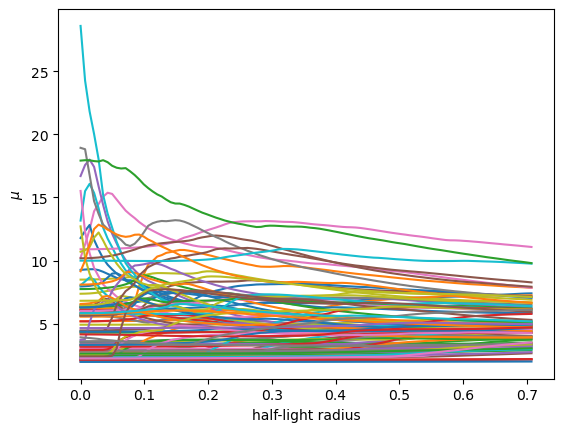

In [4]:
fig, ax = plt.subplots()

for lc in lcs:
    # plot as a function of half-light radius
    ax.plot(source.half_light_radii * ipm.pixel_scales[0], lc)

ax.set_xlabel('half-light radius')
ax.set_ylabel('$\\mu$')

plt.show()

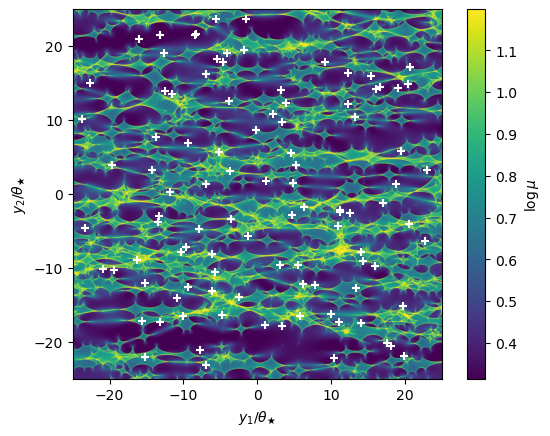

In [5]:
# plot positions on the magnification map

fig, ax = plt.subplots()

ipm.plot(ax)
ax.scatter(*positions.T, color='white', marker='+')

plt.show()

# Incorporating a microlensing lightcurve into an SNCosmo Type Ia SN model

In [6]:
ipm = IPM(verbose=1,
          kappa_tot=0.4, shear=0.4, kappa_star=0.2, 
          half_length_y1=2.5, half_length_y2=2.5, # a smaller map with high resolution
          num_pixels_y1=5000, num_pixels_y2=5000
          )
ipm.random_seed = 0
ipm.run()

Generating star field...
Done generating star field. Elapsed time: 0 seconds.

Creating children and sorting stars...
Done creating children and sorting stars. Elapsed time: 0.054 seconds.

Calculating multipole and local coefficients...
Done calculating multipole and local coefficients. Elapsed time: 0.058 seconds.

Shooting cells...
100 %
Done shooting cells. Elapsed time: 2.707 seconds.



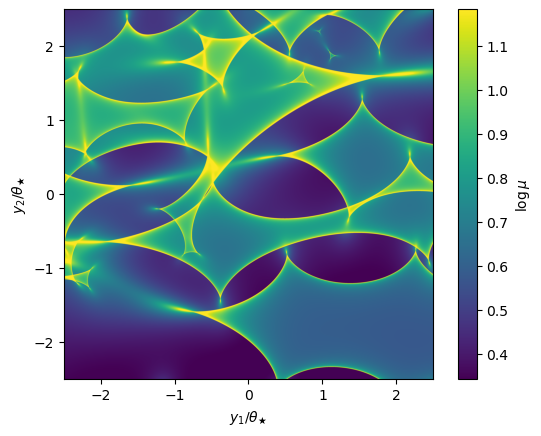

In [7]:
fig, ax = plt.subplots()
ipm.plot(ax)
plt.show()

In [8]:
import sncosmo
from astropy import units as u

from microlensing.Supernovae.chromatic_microlensing import ChromaticMicrolensing
from microlensing.Util import length_scales

In [9]:
# use a slightly more realistic Gaussian profile
source = gaussian.Gaussians(500)

In [10]:
# single lightcurve
mu = lightcurves.changing_source(ipm, source)

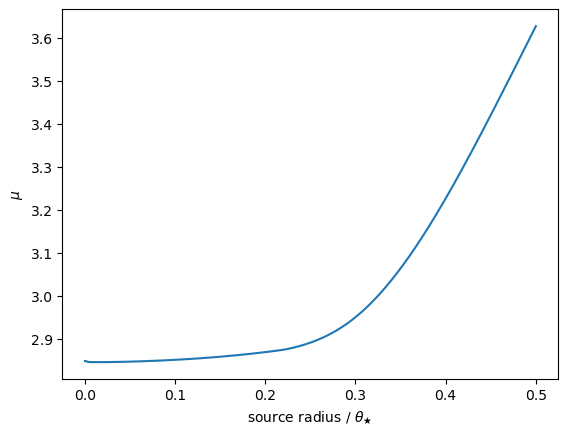

In [11]:
plt.plot(source.radii * ipm.pixel_scales[0] / ipm.theta_star, mu)
plt.xlabel("source radius / $\\theta_★$")
plt.ylabel("$\\mu$")
plt.show()

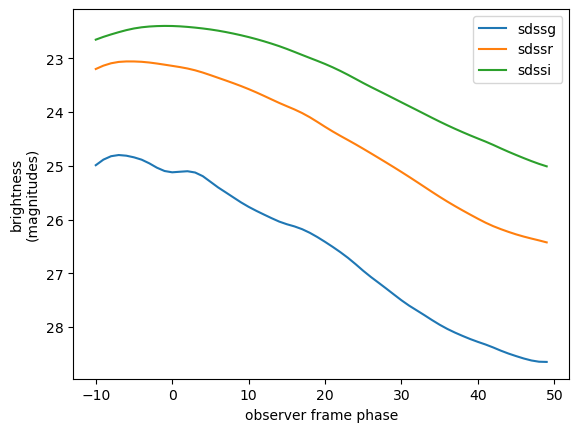

In [12]:
# magnification map was set to use stars all of mass 1 with theta_star = 1
# let us take this mass to be 0.3 solar masses
mass = 0.3 * u.M_sun

# supernova photosphere expands at 10^4 km/s
v = 10**4 * u.km / u.s

# lens and source redshifts
z_lens = 0.4
z_src = 0.8

# einstein radius of the microlenses in the lens and source planes
theta_star_lens, theta_star_src = length_scales.theta_star_physical(z_lens, z_src, mass.to(u.M_sun).value)

# calculate sn expansion rate in units of theta_star / day
sn_expansion_rate = (v * 1 * u.day / theta_star_src).to(u.dimensionless_unscaled)


# temporary Type Ia SN model without microlensing
model = sncosmo.Model(source='hsiao')
# so that we can get phases in the source rest frame
phases = np.arange(model.source.minphase(), model.source.maxphase() + 1, 1)
# and convert them to time since phase has an arbitrary zeropoint
t = phases - model.mintime()
# and then convert those times to radii. this assumes that the minimum phase is the moment
# of explosion (t=0 <-> r=0) which isn't *necessarily* true for generic sncosmo sources
# though I think it appears to be the case for most physically derived models (as why would
# you have a phase before explosion...?)
sn_radii = sn_expansion_rate * t

# interpolate mu as a function of source radius in units of theta_star
from scipy.interpolate import RegularGridInterpolator
interp = RegularGridInterpolator([source.radii * ipm.pixel_scales[0] / ipm.theta_star], mu, bounds_error=True) # but error if requesting value outside the profile size we used
mu = interp(sn_radii) # and reevaluate at the supernovae radii

# now we can create a chromatic microlensing object
# though it is technically achromatic as we are not passing wavelength information
ml = ChromaticMicrolensing(mu, phases)

# create a model with microlensing effects added
model = sncosmo.Model(source='hsiao', effects=[ml], effect_names=['microlensing'], effect_frames=['rest'])
# and set its redshift and peak magnitude
model.set(z=z_src)
model.set_source_peakabsmag(-19.3, 'bessellb', 'ab')


# finally, plot some lightcurves!
fig, ax = plt.subplots()

# observer frame phases
obs_phases = np.arange(-10, 50, 1)

for filter in ['sdssg', 'sdssr', 'sdssi']:
    ax.plot(obs_phases, model.bandmag(filter, 'ab', obs_phases), label=filter)
    
ax.invert_yaxis()
ax.set_xlabel('observer frame phase')
ax.set_ylabel('brightness\n(magnitudes)')
ax.legend()

plt.show()
